In [1]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset


In [2]:
import importlib
importlib.reload(dataset) 

MAXLEN = 50
BATCH_SIZE = 64  # 512
files = ['texts/short_table.txt', 'texts/treasure_island.txt', 'texts/ahava.txt', 'texts/rambam_mamre.txt', 'texts/ali_baba.txt', 'texts/bible.txt']

data = dataset.load_file(BATCH_SIZE, 0.1, maxlen=MAXLEN, filenames=files)


In [3]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 2**10  # larger -> quicker opening. knee at 1024

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

h = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)
# h = layers.Dropout(DROP)(h)

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)  # =l2(1e-6)
h = layers.Dropout(0.5)(h) 

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)
h = layers.Dropout(0.5)(h) 

# h = h1  # layers.Add()([h1, h])
    
h = layers.Dense(256, activation='relu', kernel_regularizer=l2(5e-5))(h)
output = layers.Dropout(0.5, name='GenericOutput')(h) 
#h = layers.Add()([h1, h])
# for k in range(1):
#     h = layers.Add()([h, Dense(256)(h)])

output_niqqud = layers.Dense(data.niqqud_texts.shape[2], name='N')(output)
output_dagesh = layers.Dense(data.dagesh_texts.shape[2], name='D')(output)

model = tf.keras.Model(inputs=[inp], outputs=[output_niqqud, output_dagesh])
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['accuracy'])

plot_model(model, to_file='model.png')
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(64, 50)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (64, 50, 1024)       74752       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (64, 50, 256)        1969152     embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (64, 50, 256)        0           bidirectional[0][0]              
______________________________________________________________________________________________

In [4]:

# log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def fit(EPOCHS):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
              # tf.keras.callbacks.EarlyStopping(patience=2, verbose=1), # monitor='accuracy', 
              # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=0, min_lr=0.0001), # monitor='loss', 
              # tensorboard_callback,
          ]
    )

history = fit(EPOCHS=15)

Train on 130464 samples, validate on 14496 samples
Epoch 1/15
130464/130464 [==============================] - 131s 1ms/sample - loss: 0.0168 - N_loss: 0.0082 - D_loss: 0.0073 - N_accuracy: 0.7997 - D_accuracy: 0.9647 - val_loss: 0.0086 - val_N_loss: 0.0045 - val_D_loss: 0.0038 - val_N_accuracy: 0.8912 - val_D_accuracy: 0.9805
Epoch 2/15
130464/130464 [==============================] - 116s 887us/sample - loss: 0.0089 - N_loss: 0.0048 - D_loss: 0.0038 - N_accuracy: 0.8904 - D_accuracy: 0.9812 - val_loss: 0.0069 - val_N_loss: 0.0036 - val_D_loss: 0.0030 - val_N_accuracy: 0.9155 - val_D_accuracy: 0.9848
Epoch 3/15
130464/130464 [==============================] - 116s 888us/sample - loss: 0.0076 - N_loss: 0.0041 - D_loss: 0.0031 - N_accuracy: 0.9061 - D_accuracy: 0.9846 - val_loss: 0.0063 - val_N_loss: 0.0032 - val_D_loss: 0.0027 - val_N_accuracy: 0.9237 - val_D_accuracy: 0.9862
Epoch 4/15
130464/130464 [==============================] - 118s 904us/sample - loss: 0.0069 - N_loss: 0.0038 -

In [ ]:
history1 = fit(EPOCHS=5)

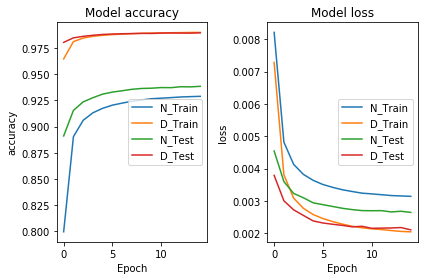

In [11]:
import matplotlib.pyplot as plt

for n, v in enumerate(['accuracy', 'loss'], 1):
    plt.subplot(1, 2, n)
    plt.plot(history.history['N_' + v][0:])
    plt.plot(history.history['D_' + v][0:])
    plt.plot(history.history['val_N_' +  v][0:])
    plt.plot(history.history['val_D_' +  v][0:])
    plt.title('Model ' + v)
    plt.ylabel(v)
    plt.xlabel('Epoch')
    plt.legend(['N_Train',  'D_Train', 'N_Test', 'D_Test'], loc='center right')
    
plt.tight_layout()

In [12]:

model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(output_niqqud), tf.keras.layers.Softmax()(output_dagesh)])

def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = model.predict(batch)
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    for a, e in zip(data.merge(batch, ns=actual_niqqud, ds=actual_dagesh), data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)):
        print(a)
        print(e)
        print()

print_predictions(2)

וּלְשָרִים אַשֶר אִתּוֹ וַיְהִי בַּבֹּקֶר וַיִּקַּח בָּלַק אֶת-בִּלְעָם וַיַּעַלְהוּ
וְלַשָּרִים אֲשֶר אִתּוֹ וַיְהִי בַבֹּקֶר וַיִּקַּח בָּלָק אֶת-בִּלְעָם וַיַּעֲלֵהוּ

אַחַר פִּדְיוֹנָן--שֶהַקְּדֵשָה חַלָּה בִּתְמוּרָה עַל בַּעְלַת מוּם קָבוּעַ:
אַחַר פִּדְיוֹנָן--שֶהַקְּדֻשָּה חָלָה בַּתְּמוּרָה עַל בַּעֲלַת מוּם קָבוּעַ:

אֵלָא בְּיָדוֹ, מִבַּחוּץ בִּפְנֵי כָּל הָעָם. וְקוֹרֵעַ אֶת כָּל הַבְּגָדִים
אֵלָא בְּיָדוֹ, מִבַּחוּץ בִּפְנֵי כָּל הָעָם. וְקוֹרֵעַ אֶת כָּל הַבְּגָדִים

בָּנִים אֶת-יָעוּש וְאֶת-שְמָרֶיה וְאֶת-זָהֶם וְאַחַרֶיה לִקַּח אֶת-מַעָכָה
בָּנִים אֶת-יְעוּש וְאֶת-שְמַרְיָה וְאֶת-זָהַם וְאַחֲרֶיהָ לָקַח אֶת-מַעֲכָה

בַּזְּמָן הַזֶּה בְּכָל מָקוֹם מִן הַתּוֹרָה, בִּפְנֵי שְלוֹשָה סְמוּכִין;
בַּזְּמָן הַזֶּה בְּכָל מָקוֹם מִן הַתּוֹרָה, בִּפְנֵי שְלוֹשָה סְמוּכִין;

אַפִלּוּ כְּסֵדֶר וִדּוּי יוֹם הַכִּפּוּרִים--אוֹמֵר; וְכֵן אִם רָצָה
אַפִלּוּ כְּסֵדֶר וִדּוּי יוֹם הַכִּפּוּרִים--אוֹמֵר; וְכֵן אִם רָצָה

יִשְרָאֵל וַיְהִי אַחַרֵי הַסְבּוּ אֹתוֹ וַתְּהִי יַד-יְהוָה בְּעִיר

In [ ]:
# model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
print(history.history['val_accuracy'])

In [ ]:
%tensorboard --logdir logs\fit